# Eigenfaces

### import packages

In [33]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import glob
from time import perf_counter
from tqdm import notebook

%matplotlib inline

### load data

In [34]:
m = 187500
n = 620

data = np.empty((m, n)) # images are 250x250x3

for i,filename in enumerate(glob.iglob('../datasets/lfw/**/*.jpg', recursive = True)):
    if i >= n:
        break
    im=Image.open(filename)
    data[:,i] = np.asarray(im).flatten()
    im.close()

In [35]:
data /= 255

In [36]:
specific_image = np.copy(data[:,0])

#### column-center the data

In [37]:
data_mean = np.expand_dims(np.mean(data, axis=1),1)
data -= data_mean

### define factorization functions

In [38]:
start = perf_counter()
det_U,_Sigma,_Vh = np.linalg.svd(data, full_matrices=False)
end = perf_counter()
det_time = end - start

def svd_rank_k(k):
    return det_U[:,:k]

In [39]:
# based on algorithms 4.1 (page 22) and 5.1 (page 29) of halko
# note that we are assuming Q has real entries in this implementation
def rsvd_rank_k(k, p=5, return_approx=False):
    if p < 0:
        raise ValueError
    l = k + p
    
    # Stage A
    omega = random.randn(n, l) # n x l
    Y = data @ omega # m x l
    Q, R = np.linalg.qr(Y) # m x l, l x l
    
    # Stage B
    B = Q.T @ data # l x n
    U_tilde,Sigma,Vh = np.linalg.svd(B, full_matrices=False)
    U = Q @ U_tilde # m x r

    if return_approx:
        return U[:,:k] @ np.diag(Sigma[:k]) @ Vh[:k]
    else:
        return U[:,:k]

### calculate eigenfaces

In [40]:
k = 350

In [41]:
det_basis = svd_rank_k(k)
print(det_basis.shape)

(187500, 350)


In [42]:
rand_basis = rsvd_rank_k(k)
print(rand_basis.shape)

(187500, 350)


In [43]:
def normalize_basis(basis):
    return (basis - np.min(basis))/(np.max(basis)-np.min(basis))

In [44]:
normalized_det_basis = normalize_basis(det_basis)

In [45]:
normalized_rand_basis = normalize_basis(rand_basis)

In [46]:
def plot_eigenfaces(basis, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(15, 15 / cols * rows))
    for i in range(rows):
        for j in range(cols):
            ax[i][j].imshow(basis[:,i * cols + j].reshape(250,250,3))

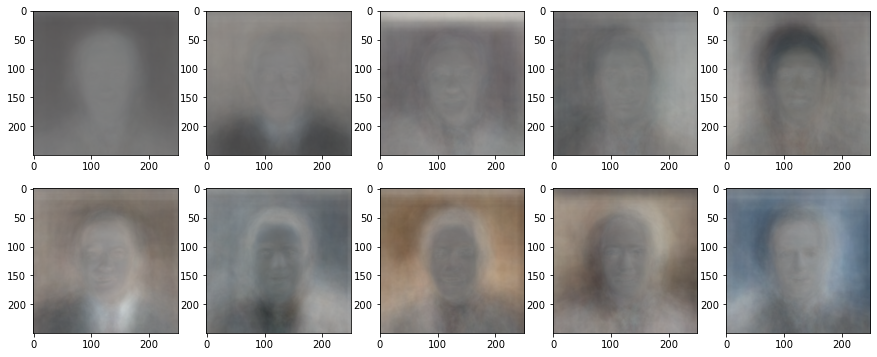

In [47]:
plot_eigenfaces(normalized_det_basis, 2, 5)

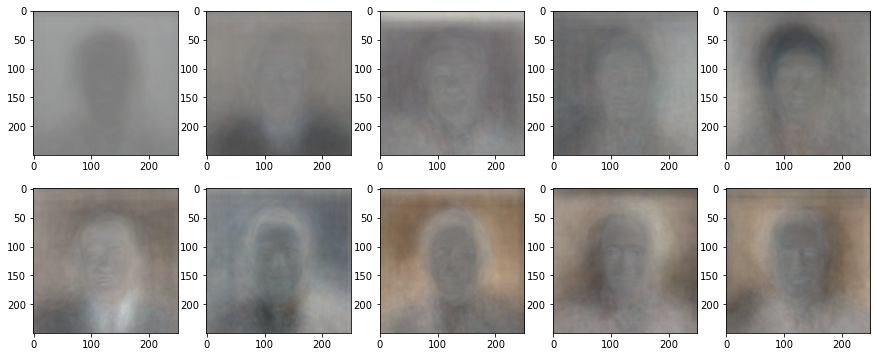

In [48]:
plot_eigenfaces(normalized_rand_basis, 2, 5)

### reconstruct an image 

In [49]:
det_coefficients = (specific_image - np.squeeze(data_mean)) @ det_basis

In [50]:
rand_coefficients = (specific_image - np.squeeze(data_mean)) @ rand_basis

In [51]:
det_reconstructed_image = np.squeeze(data_mean) + (det_basis @ det_coefficients)

In [52]:
rand_reconstructed_image = np.squeeze(data_mean) + (rand_basis @ rand_coefficients)

In [53]:
# d = 5
# reconstructed_image = np.squeeze(data_mean) + (det_basis[:,:d] @ coefficients[:d])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


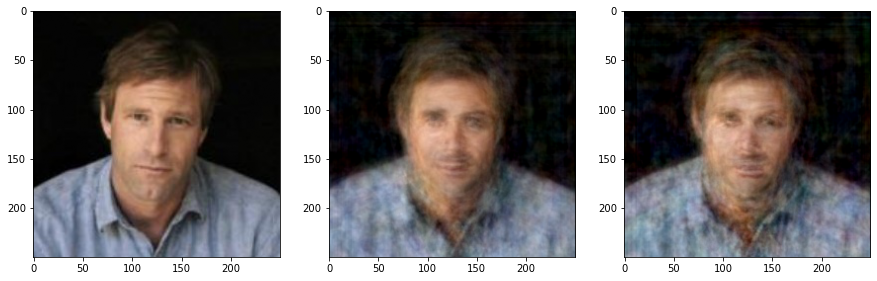

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(15,10))
ax[0].imshow(specific_image.reshape(250,250,3))
ax[1].imshow(det_reconstructed_image.reshape(250,250,3))
ax[2].imshow(rand_reconstructed_image.reshape(250,250,3))

### evaluate performance

In [55]:
domain = np.arange(50, 500, step=50)

rand_times = []
errors = []

for k in domain:
    print(f'Computing RSVD with rank k={k}...')
    
    det_basis = svd_rank_k(k)
    det_approx = det_basis @ np.diag(_Sigma[:k]) @ _Vh[:k]
    
    start = perf_counter()
    rand_approx = rsvd_rank_k(k, return_approx=True)
    end = perf_counter()
    rand_time = end - start
    
    rand_times.append(rand_time / det_time)
    
    # sketchy fix for negative basis vectors
    #for i in range(k):
    #    if np.dot(det_basis[:,i], rand_basis[:,i]) < 0:
    #        rand_basis[:,i] *= -1
    
    
    error = np.linalg.norm(rand_approx - det_approx) / np.linalg.norm(det_basis) #relative error between rsvd and svd
    #if we want, we can look at relative error between rsvd and data as well
    errors.append(error)

Computing RSVD with rank k=50...
Computing RSVD with rank k=100...
Computing RSVD with rank k=150...
Computing RSVD with rank k=200...
Computing RSVD with rank k=250...
Computing RSVD with rank k=300...
Computing RSVD with rank k=350...
Computing RSVD with rank k=400...
Computing RSVD with rank k=450...


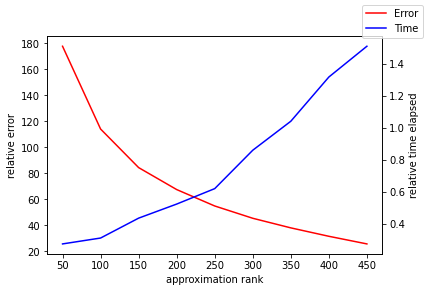

In [56]:
fig, ax = plt.subplots()

ax.set_xlabel('approximation rank')

ax.plot(domain, errors, c='r', label='Error')
ax.set_ylabel('relative error')

ax2 = ax.twinx()

ax2.plot(domain, rand_times, c='b', label='Time')
ax2.set_ylabel('relative time elapsed')

fig.legend(loc='upper right')

### statistics on rsvd

In [57]:
n_sample = 10
rsvd_error = np.empty((domain.shape[0], n_sample))
svd_error = np.empty(domain.shape[0])

rsvd_stat = np.empty((7,domain.shape[0]))

for i in range(domain.shape[0]):
    print(f'Sampling with rank k={domain[i]}')
    svd_error[i] = np.linalg.norm((det_U[:,:domain[i]] @ np.diag(_Sigma[:domain[i]]) @ _Vh[:domain[i]]) - data) / np.linalg.norm(data)
    for j in range(n_sample):
        rsvd_error[i][j] = np.linalg.norm(rsvd_rank_k(domain[i],return_approx=True) - data) / np.linalg.norm(data)


Sampling with rank k=50
Sampling with rank k=100
Sampling with rank k=150
Sampling with rank k=200
Sampling with rank k=250
Sampling with rank k=300
Sampling with rank k=350
Sampling with rank k=400
Sampling with rank k=450


In [58]:
for i in range(domain.shape[0]):
    rsvd_stat[0][i] = np.min(rsvd_error[i])
    rsvd_stat[1][i] = np.quantile(rsvd_error[i], 0.25)
    rsvd_stat[2][i] = np.median(rsvd_error[i])
    rsvd_stat[3][i] = np.quantile(rsvd_error[i], 0.75)
    rsvd_stat[4][i] = np.max(rsvd_error[i])
    rsvd_stat[5][i] = np.mean(rsvd_error[i])
    rsvd_stat[6][i] = np.std(rsvd_error[i])

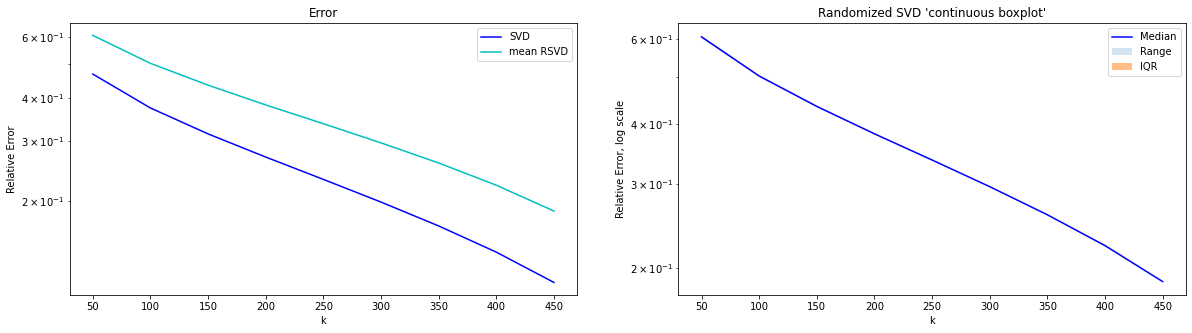

In [59]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].plot(domain, svd_error, c='b', label='SVD')
ax[0].plot(domain, rsvd_stat[5], c='c', label='mean RSVD')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Relative Error')
ax[0].set_yscale('log')
ax[0].legend(loc='upper right')
ax[0].set_title('Error')

ax[1].plot(domain, rsvd_stat[2], c='b', label='Median')
ax[1].fill_between(domain, rsvd_stat[4], rsvd_stat[0], alpha=0.2, label='Range')
ax[1].fill_between(domain, rsvd_stat[1], rsvd_stat[3], alpha=0.5, label='IQR')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Relative Error, log scale')
ax[1].set_yscale('log')
ax[1].legend(loc='upper right')
ax[1].set_title('Randomized SVD \'continuous boxplot\'')


plt.show()

In [60]:
print(f"For k=200: Mean={rsvd_stat[5][3]}, StDev={rsvd_stat[6][3]}")

For k=200: Mean=0.38073557027131055, StDev=0.0008712639307858715
